# Problem Definition

## Tujuan analisis

mencari tahu ujaran kebencian atau hate speech di twitter dan memprediksi apakah sebuah kalimat mengandung ujaran kebencian atau tidak

## Batasan Masalah

  1. Hanya menggunakan dataset dari kaggle dan yang diberikan oleh binar

# Data Preparation

## Data Sekunder

data diambil dari kaggle dan challenge asset binar

## Data Cleansing

### install PySastrawi

In [23]:
%pip install pysastrawi

### Impport Library

In [2]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore # type: ignore
import seaborn as sns # type: ignore # type: ignore
from collections import Counter, OrderedDict

### Load Data, Metadata, and Check

In [4]:
df = pd.read_csv('../../archive/data.csv', encoding='latin-1')

alay = pd.read_csv('../../archive/new_kamusalay.csv', encoding='latin-1', header=None)

idstopword = pd.read_csv('../../archive/stopwordbahasa.csv', header=None)
idstopword = idstopword.rename(columns={0: 'stopword'})

abusive = pd.read_csv('../../archive/abusive.csv')['ABUSIVE'].tolist()

In [5]:
df.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0,1,0,0,0,0,0,0,0,0,0,0
8,Nah admin belanja satu lagi port terbaik nak m...,0,0,0,0,0,0,0,0,0,0,0,0
9,USER Enak lg klo smbil ngewe',0,1,0,0,0,0,0,0,0,0,0,0


### About this data
Here we provide our dataset for multi-label hate speech and abusive language detection in the Indonesian Twitter. The main dataset can be seen at **re_dataset** with labels information as follows:

* **HS** : hate speech label;
* **Abusive** : abusive language label;
* **HS_Individual** : hate speech targeted to an individual;
* **HS_Group** : hate speech targeted to a group;
* **HS_Religion** : hate speech related to religion/creed;
* **HS_Race** : hate speech related to race/ethnicity;
* **HS_Physical** : hate speech related to physical/disability;
* **HS_Gender** : hate speech related to gender/sexual orientation;
* **HS_Other** : hate related to other invective/slander;
* **HS_Weak** : weak hate speech;
* **HS_Moderate** : moderate hate speech;
* **HS_Strong** : strong hate speech.

For each label, `1` means `yes` (tweets including that label), `0` mean `no` (tweets are not included in that label).

In [6]:
print("positively toxic: ", df[(df['HS'] == 1) | (df['Abusive'] == 1)].shape)
print("negatively toxic: ", df[(df['HS'] == 0) | (df['Abusive'] == 1)].shape)

positively toxic:  (7309, 13)
negatively toxic:  (10903, 13)


In [7]:
alay.head(10)

,0,1
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [8]:
idstopword.head(5)

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


In [9]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


### Cleansing Function

In [10]:
import re
import unicodedata
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # type: ignore

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat semua huruf menjadi kecil
def lowercase(text):
    return text.lower()

# menghilangkan character yang tidak perlu
def remove_unnecessary_char(text):
    text = re.sub(r'(@[\w]*|rt|https?://\S+|#\S+|\n)', ' ', text)
    text = re.sub(r'  +', ' ', text)
    return text.strip()

# menghilangkan emoticon
def remove_emoticon(text):
    ascii_emoticon_pattern = r'[:;=8][\-~]?[)\(DPOp]'
    unicode_emoticon_pattern = r'[\U0001F600-\U0001F64F]|\u263A-\u263C|\u2764|\u270B|\U0001F910-\U0001F92F|\U0001F300-\u0001F5FF|\U0001F680-\U0001F6FF|\U0001F700-\U0001F77F]'
    combined_pattern = f'{ascii_emoticon_pattern}|{unicode_emoticon_pattern}'
    text = re.sub(combined_pattern, '', text)
    return text

# hapus kata yang berawalan x-- yang diakhiri 2 heksadesimal
def remove_unicode(text):
    text = re.sub(r'\bx[a-fA-F0-9]{2}\b', '', text)
    text = re.sub(r'\bx([a-fA-F0-9]{2})', '', text)
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

def normalize_alay(text, alaymap):
    return ' '.join([alaymap[word] if word in alaymap else word for word in text.split(' ')])

def remove_stopword(text, stopwords):
    text = ' '.join(['' if word in stopwords else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text, stemmer):
    return stemmer.stem(text)

def textpreprocess(text, stopwords, alaymap, stemmer):
    text = lowercase(text)
    text = remove_unnecessary_char(text)
    text = remove_emoticon(text)
    text = remove_unicode(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_alay(text, alaymap)
    text = stemming(text, stemmer)
    text = remove_stopword(text, stopwords)
    return text


In [11]:
Before = df['Tweet']
Before

0        - disaat semua cowok berusaha melacak perhatia...
1        RT USER: USER siapa yang telat ngasih tau elu?...
2        41. Kadang aku berfikir, kenapa aku tetap perc...
3        USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4        USER USER Kaum cebong kapir udah keliatan dong...
                               ...                        
13164    USER jangan asal ngomong ndasmu. congor lu yg ...
13165                         USER Kasur mana enak kunyuk'
13166    USER Hati hati bisu :( .g\n\nlagi bosan huft \...
13167    USER USER USER USER Bom yang real mudah terdet...
13168    USER Mana situ ngasih(": itu cuma foto ya kuti...
Name: Tweet, Length: 13169, dtype: object

In [12]:
# Create dictionary for alay words
alay_dict = dict(zip(alay[0], alay[1]))

# List of stopwords
stopwords = idstopword['stopword'].tolist()

# Apply text preprocessing
df['Tweet'] = df['Tweet'].apply(lambda x: textpreprocess(x, stopwords, alay_dict, stemmer))

after = df['Tweet']
after

0        cowok usaha lacak perhati gue lantas remeh per...
1        user user telat tau edan sarap gue gaul cigax ...
2        41 kadang pikir percaya tuhan jatuh kali kali ...
3                        user user ku tau mata sipit lihat
4        user user kaum cebong kafir lihat dongok dungu...
                               ...                        
13164              user bicara ndasmu congor sekata anjing
13165                               user kasur enak kunyuk
13166                        user hati hati bisu bosan duh
13167    user user user user bom real mudah deteksi bom...
13168                         user situ foto ya kutil onta
Name: Tweet, Length: 13169, dtype: object

In [13]:
df.head(10)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0,1,1,0,0
1,user user telat tau edan sarap gue gaul cigax ...,0,1,0,0,0,0,0,0,0,0,0,0
2,41 kadang pikir percaya tuhan jatuh kali kali ...,0,0,0,0,0,0,0,0,0,0,0,0
3,user user ku tau mata sipit lihat,0,0,0,0,0,0,0,0,0,0,0,0
4,user user kaum cebong kafir lihat dongok dungu...,1,1,0,1,1,0,0,0,0,0,1,0
5,user ya bani taplak kawan kawan,1,1,0,1,0,0,0,0,1,0,1,0
6,deklarasi pilih kepala daerah 2018 aman anti h...,0,0,0,0,0,0,0,0,0,0,0,0
7,gue selesai re watch aldnoah zero kampret 2 ka...,0,1,0,0,0,0,0,0,0,0,0,0
8,admin belanja po nak makan ais kepal milo ais ...,0,0,0,0,0,0,0,0,0,0,0,0
9,user enak ngewe,0,1,0,0,0,0,0,0,0,0,0,0


# EDA - Exploratory Data Analyst


### Common Toxic World

In [14]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from wordcloud import WordCloud # type: ignore


In [15]:
toxictweet = []

for tweet in df['Tweet'].str.split():
  for word in tweet:
    if len(word) > 0 and word in abusive:
      toxictweet.append(word)

In [16]:
counter_tweets = Counter(toxictweet).most_common()[:1000]

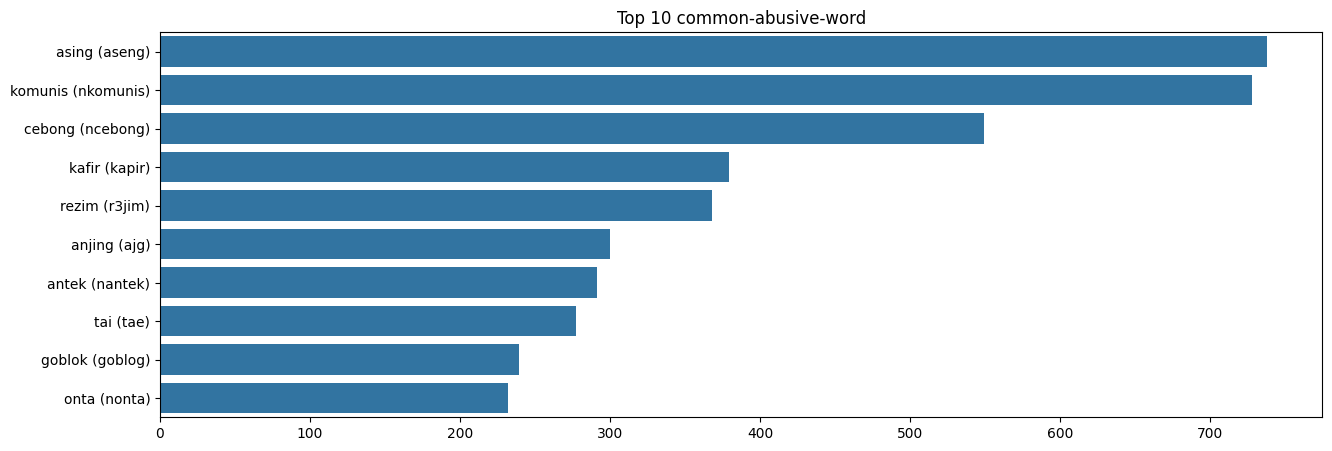

In [17]:
toptweets = OrderedDict(counter_tweets)

show_only = 10

keys = list(toptweets.keys())
vals = [toptweets[k] for k in keys]

original_slang = []
for word in keys:
  if word in alay[1].values:
    original_slang.append(alay.loc[alay[1] == word, 0].values[0])
  else:
    original_slang.append(word)

combined_words = [f'{keys[i]} ({original_slang[i]})' for i in range(len(keys))]

plt.figure(figsize=(15, 5))
sns.barplot(x=vals[:show_only], y=combined_words[:show_only])
plt.title('Top 10 common-abusive-word')
plt.show()

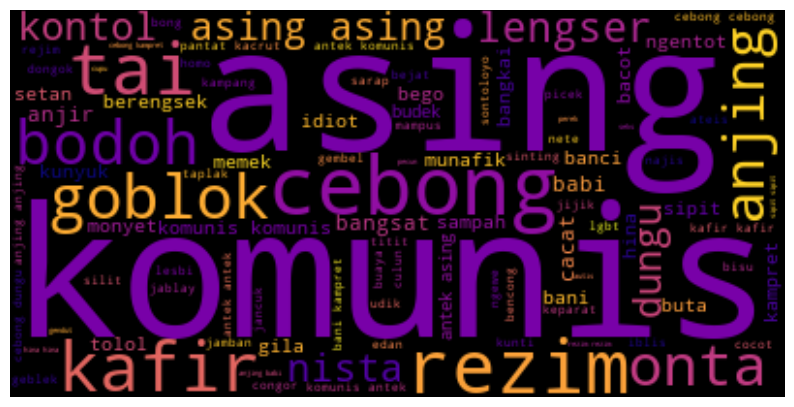

In [18]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 8))
tokens_ = ' '.join(toxictweet)
wc_ = WordCloud(max_words=100, background_color='black', max_font_size=100, colormap='plasma').generate(tokens_)
axes.axis("off")
axes.imshow(wc_, interpolation="bilinear")
plt.show()

### Label Distribution

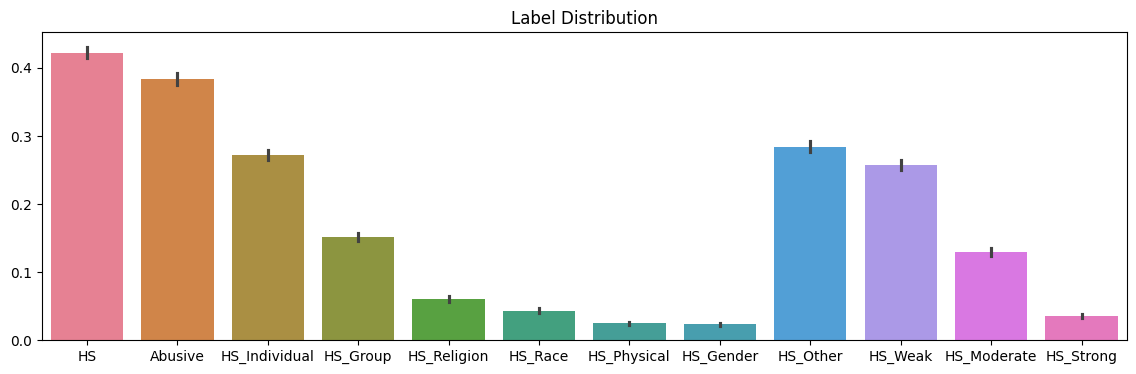

In [19]:
plt.figure(figsize=(14,4))
plt.title('Label Distribution')
sns.barplot(df)
plt.show()

In [20]:
df1 = df.drop(['Tweet'], axis=1)
df2 = df1.sum()
df2

HS               5561
Abusive          5043
HS_Individual    3575
HS_Group         1986
HS_Religion       793
HS_Race           566
HS_Physical       323
HS_Gender         306
HS_Other         3740
HS_Weak          3383
HS_Moderate      1705
HS_Strong         473
dtype: int64

In [21]:
counts = {}
for column in df1.columns:
    counts[column] = {
        "Toxic Free (0)": (df1[column] == 0).sum(),
        "Toxic (1)": (df1[column] == 1).sum()
    }

counts_df = pd.DataFrame(counts)
print(counts_df)

                  HS  Abusive  HS_Individual  HS_Group  HS_Religion  HS_Race  \
Toxic Free (0)  7608     8126           9594     11183        12376    12603   
Toxic (1)       5561     5043           3575      1986          793      566   

                HS_Physical  HS_Gender  HS_Other  HS_Weak  HS_Moderate  \
Toxic Free (0)        12846      12863      9429     9786        11464   
Toxic (1)               323        306      3740     3383         1705   

                HS_Strong  
Toxic Free (0)      12696  
Toxic (1)             473  


## Splitting and Balancing File

In [22]:
df_HS = df[['Tweet', 'HS']]
df_Abusive = df[['Tweet', 'Abusive']]
df_Individual = df[['Tweet', 'HS_Individual']]
df_Group = df[['Tweet', 'HS_Group']]
df_Religion = df[['Tweet', 'HS_Religion']]
df_Race = df[['Tweet', 'HS_Race']]
df_Physical = df[['Tweet', 'HS_Physical']]
df_Gender = df[['Tweet', 'HS_Gender']]
df_Other = df[['Tweet', 'HS_Other']]
df_Weak = df[['Tweet', 'HS_Weak']]
df_Moderate = df[['Tweet', 'HS_Moderate']]
df_Strong = df[['Tweet', 'HS_Strong']]

In [23]:
df_HS_1 = df_HS[df_HS['HS'] == 1]
df_HS_0 = df_HS[df_HS['HS'] == 0].iloc[:5561] #hanya mengambil 5561 data pertama yang memiliki nilai HS = 0, sesuai patokan tadi
df_HS_bal = pd.concat([df_HS_1, df_HS_0], axis=0)
df_HS_bal.shape

(11122, 2)

In [24]:
df_Abusive_1 = df_Abusive[df_Abusive['Abusive'] == 1]
df_Abusive_0 = df_Abusive[df_Abusive['Abusive'] == 0].iloc[:5043]
df_Abusive_bal = pd.concat([df_Abusive_1, df_Abusive_0], axis=0)
df_Abusive_bal.shape

(10086, 2)

In [25]:
df_Individual_1 = df_Individual[df_Individual['HS_Individual'] == 1]
df_Individual_0 = df_Individual[df_Individual['HS_Individual'] == 0].iloc[:3575]
df_Individual_bal = pd.concat([df_Individual_1, df_Individual_0], axis=0)
df_Individual_bal.shape

(7150, 2)

In [26]:
df_Group_1 = df_Group[df_Group['HS_Group'] == 1]
df_Group_0 = df_Group[df_Group['HS_Group'] == 0].iloc[:1986]
df_Group_bal = pd.concat([df_Group_1, df_Group_0], axis=0)
df_Group_bal.shape

(3972, 2)

In [27]:
df_Religion_1 = df_Religion[df_Religion['HS_Religion'] == 1]
df_Religion_0 = df_Religion[df_Religion['HS_Religion'] == 0].iloc[:793]
df_Religion_bal = pd.concat([df_Religion_1, df_Religion_0], axis=0)
df_Religion_bal.shape

(1586, 2)

In [28]:
df_Race_1 = df_Race[df_Race['HS_Race'] == 1]
df_Race_0 = df_Race[df_Race['HS_Race'] == 0].iloc[:566]
df_Race_bal = pd.concat([df_Race_1, df_Race_0], axis=0)
df_Race_bal.shape

(1132, 2)

In [29]:
df_Physical_1 = df_Physical[df_Physical['HS_Physical'] == 1]
df_Physical_0 = df_Physical[df_Physical['HS_Physical'] == 0].iloc[:323]
df_Physical_bal = pd.concat([df_Physical_1, df_Physical_0], axis=0)
df_Physical_bal.shape

(646, 2)

In [30]:
df_Gender_1 = df_Gender[df_Gender['HS_Gender'] == 1]
df_Gender_0 = df_Gender[df_Gender['HS_Gender'] == 0].iloc[:306]
df_Gender_bal = pd.concat([df_Gender_1, df_Gender_0], axis=0)
df_Gender_bal.shape

(612, 2)

In [31]:
df_Other_1 = df_Other[df_Other['HS_Other'] == 1]
df_Other_0 = df_Other[df_Other['HS_Other'] == 0].iloc[:3740]
df_Other_bal = pd.concat([df_Other_1, df_Other_0], axis=0)
df_Other_bal.shape

(7480, 2)

In [32]:
df_Weak_1 = df_Weak[df_Weak['HS_Weak'] == 1]
df_Weak_0 = df_Weak[df_Weak['HS_Weak'] == 0].iloc[:3383]
df_Weak_bal = pd.concat([df_Weak_1, df_Weak_0], axis=0)
df_Weak_bal.shape

(6766, 2)

In [33]:
df_Moderate_1 = df_Moderate[df_Moderate['HS_Moderate'] == 1]
df_Moderate_0 = df_Moderate[df_Moderate['HS_Moderate'] == 0].iloc[:1705]
df_Moderate_bal = pd.concat([df_Moderate_1, df_Moderate_0], axis=0)
df_Moderate_bal.shape

(3410, 2)

In [34]:
df_Strong_1 = df_Strong[df_Strong['HS_Strong'] == 1]
df_Strong_0 = df_Strong[df_Strong['HS_Strong'] == 0].iloc[:473]
df_Strong_bal = pd.concat([df_Strong_1, df_Strong_0], axis=0)
df_Strong_bal.shape

(946, 2)

In [35]:
df_HS_bal.to_csv("kHS.csv")
df_Abusive_bal.to_csv("kAbusive.csv")
df_Individual_bal.to_csv("kIndividual.csv")
df_Group_bal.to_csv("kGroup.csv")
df_Religion_bal.to_csv("kReligion.csv")
df_Race_bal.to_csv("kRace.csv")
df_Physical_bal.to_csv("kPhysical.csv")
df_Gender_bal.to_csv("kGender.csv")
df_Other_bal.to_csv("kOther.csv")
df_Weak_bal.to_csv("kWeak.csv")
df_Moderate_bal.to_csv("kModerate.csv")
df_Strong_bal.to_csv("kStrong.csv")